# Unit 7 | Assignment - Distinguishing Sentiments

### Analysis
- On average, the BBC had the most negative sentiment while the New York times, while still negative, was the least out of all the media outlets.
- A majority of tweets seem to be neutral, while the averages are skewed by a relatively small number of very negative and very positive tweets.
- Average tweet polarity between the different media outlets averages a .1 difference between the lowest and highest tweet polarity scores. This means that most of the media outlets had pretty similar underlying negative sentiment while tweeting.

In [1]:
# Dependencies
import tweepy
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Pull all tweet data

In [2]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
consumerKey = 'LqyVgiQR623hgzkiFniUVtPbp'
consumerSecret = '8zmujVSE8X9TgHHeB68np9XPJ0uGnIaIElE9BUGwOpkINArAE9'
accessToken = '148433925-MO7mx9x62sGpuk39xY0GU5XCZVk46YKWjXh3l2CT'
accessTokenSecret = 'QQtag1M9uVrc5w350TNb3sWVx9uDPh0WHhhMK70tQzxGh'

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumerKey,consumerSecret)
auth.set_access_token(accessToken,accessTokenSecret)
api = tweepy.API(auth)

# Target User Account (using dictionary)
targetUsers = {'@BBCNews' : 'BBC',
               '@CBSNews': 'CBS',
               '@CNN' : 'CNN',
               '@FoxNews' : 'Fox',
               '@nytimes' : 'NYT'}

# Final Dictionary
dataDict = {}
dKeys = ['Twitter Account','Number of Tweets Ago','Date','Tweet','Compound Score','Positive Score','Neutral Score','Negative Score'] #dictionary keys

# Number of tweets to pull
n = 100

# Variables for holding returned data
userName = []
tweetsAgoList = []
dateList = []
textList = []
compoundList = []
positiveList = []
negativeList = []
neutralList = []
# List of all variables
dataHolder = [userName,tweetsAgoList,dateList,textList,compoundList,positiveList,negativeList,neutralList]

# Cycle through all users and get tweet data
for twitterhandle,outletName in targetUsers.items():
    c = 1 #set counter

    # Iterate through all status's using Tweepy Cursor
    for page in tweepy.Cursor(api.user_timeline, id=twitterhandle).pages(n):

        # Make page into JSON to grab data
        page = page[0]
        tweet = json.dumps(page._json, indent=3)
        tweet = json.loads(tweet)

        # Save values
        tweetsAgo = c
        date = tweet['created_at']
        text = tweet['text']

        # Run Vader Analysis on each tweet and save values
        comp = analyzer.polarity_scores(text)["compound"]
        pos = analyzer.polarity_scores(text)["pos"]
        neu = analyzer.polarity_scores(text)["neu"]
        neg = analyzer.polarity_scores(text)["neg"]

        allVariables = [outletName,tweetsAgo,date,text,comp,pos,neu,neg]

        for h, v in zip(dataHolder, allVariables):
            h.append(v)

        c += 1

# Create dictionary of values for DataFrame
for h, k in zip(dataHolder, dKeys):
    dataDict[k] = h

## Create DataFrame with Twitter Data

In [7]:
# Create DataFrame
tweetDataDF = pd.DataFrame(dataDict)
tweetDataDF = tweetDataDF[dKeys]

# Export data
tweetDataDF.to_csv('output/tweetData.csv')

tweetDataDF.head()

,Twitter Account,Number of Tweets Ago,Date,Tweet,Compound Score,Positive Score,Neutral Score,Negative Score
0,BBC,1,Mon Jan 15 07:02:40 +0000 2018,Carillion to go into liquidation https://t.co/...,0.0000,0.000,1.000,0.000
1,BBC,2,Sun Jan 14 13:00:52 +0000 2018,Cassie Hayes death: Tribute to Tui Southport t...,-0.5994,0.000,0.698,0.302
2,BBC,3,Sun Jan 14 03:00:30 +0000 2018,Sturgeon: UK Brexit plan 'beggars belief' http...,0.0000,0.000,1.000,0.000
3,BBC,4,Sat Jan 13 01:26:11 +0000 2018,Nottingham railway station to reopen after hug...,-0.0258,0.197,0.598,0.205
4,BBC,5,Fri Jan 12 19:30:34 +0000 2018,RT @BBCSport: Ryan Giggs and Craig Bellamy hav...,0.0000,0.000,1.000,0.000


## Sentiment Analysis per Media Status

In [8]:
# Slice Tweet DF for individual news outlets
compDF = tweetDataDF[['Twitter Account','Number of Tweets Ago','Compound Score']]

autoList = [] #list placeholder

# Create list of DFs for each media outlet
for k,v in targetUsers.items():
    x = compDF['Twitter Account'] == v
    z = compDF[x]
    z = z.rename(columns={'Compound Score':v})
    z = z.drop(['Twitter Account'], axis=1)
    autoList.append(z)

# Merge new Dataframes
l = len(autoList)
n = 0
mergedCompDF = autoList[0]
while n < l-1:
    mergedCompDF = pd.merge(mergedCompDF,autoList[n+1],on='Number of Tweets Ago')
    n += 1

mergedCompDF.head()

,Number of Tweets Ago,BBC,CBS,CNN,Fox,NYT
0,1,0.0000,0.0000,-0.2023,-0.5267,0.9147
1,2,-0.5994,-0.3182,0.6209,0.0000,-0.3818
2,3,0.0000,-0.7579,-0.4404,-0.7845,0.4588
3,4,-0.0258,-0.3182,-0.0772,0.1280,0.0000
4,5,0.0000,-0.3612,-0.8735,-0.4767,0.0000


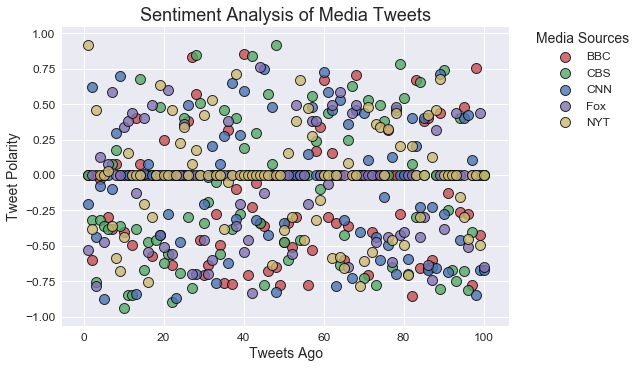

In [14]:
# Set color scheme
deep=["#C44E52", "#55A868", "#4C72B0", "#8172B2", "#CCB974", "#64B5CD"]

# Create plot with all news outlets
axBBC = mergedCompDF.plot(kind='scatter', x='Number of Tweets Ago', y='BBC', color=deep[0], label='BBC', s=100, linewidths = 1, edgecolors = 'k', alpha=0.8)    
axCBS = mergedCompDF.plot(kind='scatter', x='Number of Tweets Ago', y='CBS', color=deep[1], ax=axBBC, label='CBS', s=100, linewidths = 1, edgecolors = 'k', alpha=0.8)    
axCNN = mergedCompDF.plot(kind='scatter', x='Number of Tweets Ago', y='CNN', color=deep[2], ax=axBBC, label='CNN', s=100, linewidths = 1, edgecolors = 'k', alpha=0.8)    
axFOX = mergedCompDF.plot(kind='scatter', x='Number of Tweets Ago', y='Fox', color=deep[3], ax=axBBC, label='Fox', s=100, linewidths = 1, edgecolors = 'k', alpha=0.8)    
axNYT = mergedCompDF.plot(kind='scatter', x='Number of Tweets Ago', y='NYT', color=deep[4], ax=axBBC, label='NYT', s=100, linewidths = 1, edgecolors = 'k', alpha=0.8)    

plt.title('Sentiment Analysis of Media Tweets',fontsize=18) #Create graph title
plt.xlabel('Tweets Ago', fontsize=14) #Create x-axis label
plt.ylabel('Tweet Polarity', fontsize=14) #Create y-axis label
plt.tick_params(axis='both', labelsize=12) #Format Axis
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Media Sources', fontsize=12)
legend.get_title().set_fontsize('14') #Set legend title font size

plt.savefig('output/scatterplot.png') #save plot
plt.show() #show plot

## Overall Media Sentiment

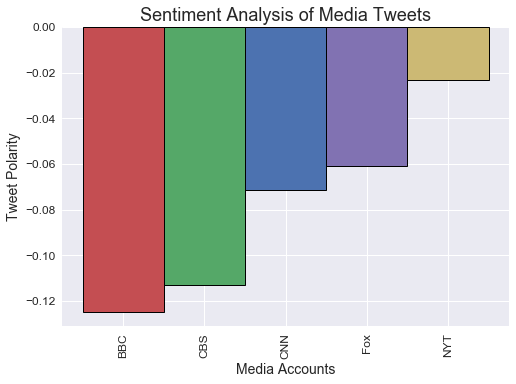

In [10]:
# Create groupby Twitter Account DataFrame to plot
mediaOutletGB = tweetDataDF.groupby('Twitter Account')
compoundSum = mediaOutletGB['Compound Score'].mean() #get mean of compound score
mediaOutletDF = pd.DataFrame({'Mean Compound Score' : compoundSum}) #create DF

ax = mediaOutletDF.plot.bar(subplots=True,
                            legend=False,
                            width=1,
                            color=deep,
                            linewidth = 1,
                            edgecolor = 'k')

plt.title('Sentiment Analysis of Media Tweets',fontsize=18) #Create graph title
plt.xlabel('Media Accounts', fontsize=14) #Create x-axis label
plt.ylabel('Tweet Polarity', fontsize=14) #Create y-axis label
plt.tick_params(axis='both', labelsize=12) #Format Axis


plt.savefig('output/barplot.png')
plt.show()